In [1]:
# Topic modeling.
# Random seed for reproducibility.
import numpy as np
np.random.seed(42)

import os
import pickle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# Created a cache directory, only if it's not available.
cache_dir = "cache"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)


def get_cache_path(filename):
    return os.path.join(cache_dir, filename)

def save_to_cache(obj, filename):
    with open(get_cache_path(filename), 'wb') as f:
        pickle.dump(obj, f)

# Load from cache.
def load_from_cache(filename):
    cache_path = get_cache_path(filename)
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            return pickle.load(f)
    return None

In [3]:
# Loaded from the cache files.
df_clean = None
cache_files = ["best_quality_data.pkl"]

for cache_file in cache_files:
    print(f"Attempting to load {cache_file}.")
    try:
        df_clean = load_from_cache(cache_file)
        if df_clean is not None and 'cleaned_text' in df_clean.columns:
            print(f"Successfully loaded data from {cache_file}")
            print(f"DataFrame shape: {df_clean.shape}")
            print(f"Columns: {df_clean.columns.tolist()}")
            break
        else:
            if df_clean is None:
                print(f"File {cache_file} not found or could not be loaded.")
            else:
                print(f"File {cache_file} loaded but the cleaned text column is missing.")
            df_clean = None
    except Exception as e:
        print(f"Error loading {cache_file}: {e}")
        df_clean = None

if df_clean is None:
    print("Error: Could not load valid data.")
else:
    print(f"Data loaded with {len(df_clean)} articles.")

Attempting to load best_quality_data.pkl...
Successfully loaded data from best_quality_data.pkl
DataFrame shape: (184391, 13)
Columns: ['url', 'date', 'language', 'title', 'text', 'cleaned_text', 'year', 'month', 'yearmonth', 'is_relevant', 'source_domain', 'trafilatura_text', 'trafilatura_title']
Data loaded with 184391 articles


In [4]:
def run_topic_modeling(df_input, num_topics=10, force_recompute=False):
    if df_input is None:
        print("Error: Input DataFrame is None.")
        return None, None, None, None
        
    if 'cleaned_text' not in df_input.columns:
        print("Error: Input DataFrame has no cleaned text column.")
        print(f"Available columns: {df_input.columns.tolist()}")
        return None, None, None, None
    
    cache_file = f"topic_model_{num_topics}.pkl"
    
    # Results
    if not force_recompute:
        cached_data = load_from_cache(cache_file)
        if cached_data is not None:
            print("Loaded topic model from cache.")
            return cached_data
    
    print("Running topic modeling.")
    
    documents = df_input['cleaned_text'].tolist()
    if not documents:
        print("Error: No documents found in the cleaned text column.")
        return None, None, None, None
    
    # Used the CountVectorizer.
    print("Creating the document term matrix.")
    vectorizer = CountVectorizer(
        max_df=0.7,
        min_df=10,
        max_features=10000,
        ngram_range=(1, 2),
        stop_words='english'
    )
    
    # Created the document term matrix.
    try:
        X = vectorizer.fit_transform(documents)
        feature_names = vectorizer.get_feature_names_out()
    except Exception as e:
        print(f"Error in vectorization: {e}")
        return None, np.array([0] * len(documents)), [], []
    
    # Trained the LDA model.
    print(f"Training LDA model with {num_topics} topics.")
    lda = LatentDirichletAllocation(
        n_components=num_topics,
        max_iter=10,
        random_state=42,
        n_jobs=-1
    )
    
    # Fitted the model and transforming the documents.
    try:
        doc_topic_dists = lda.fit_transform(X)
        
        # Most probable topic for each document.
        doc_topics = doc_topic_dists.argmax(axis=1)
        
        # Extracted the top terms for each topic.
        topic_terms = []
        for topic_idx, topic in enumerate(lda.components_):
            top_features_ind = topic.argsort()[:-10 - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            topic_terms.append(top_features)
        
        # Saved topic model, document topics and feature names.
        result = (lda, doc_topics, feature_names, topic_terms)
        save_to_cache(result, cache_file)
        
        return result
    except Exception as e:
        print(f"Error in topic modeling: {e}")
        return None, np.array([0] * len(documents)), [], []

def plot_topics(lda, feature_names, n_top_words=10, save_path=None):
    fig, axes = plt.subplots(5, 2, figsize=(15, 25), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(lda.components_):
        if topic_idx >= len(axes):
            break
            
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights)
        ax.set_title(f'Topic {topic_idx + 1}', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xlabel('Weight', fontsize=14)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    return fig

def plot_topics_over_time(df, topics, topic_terms, top_n_topics=5, save_path=None):
    # DataFrame with the topics.
    topic_df = pd.DataFrame({'date': df['date'], 'topic': topics})
    
    # Counts of each topic.
    topic_counts = {}
    for topic in range(max(topics) + 1):
        topic_counts[topic] = np.sum(topics == topic)
    
    # Top topics.
    top_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)
    top_topics = [topic for topic, count in top_topics[:top_n_topics]]
    
    # Top topics by month.
    topic_df = topic_df[topic_df['topic'].isin(top_topics)]
    topic_df['yearmonth'] = topic_df['date'].dt.strftime('%Y-%m')
    
    # Topics per month.
    topic_time = topic_df.groupby(['yearmonth', 'topic']).size().reset_index(name='count')
    
    # Datetime.
    topic_time['date'] = pd.to_datetime(topic_time['yearmonth'] + '-01')
    topic_time = topic_time.sort_values('date')
    
    # Pivot table.
    pivot_df = topic_time.pivot(index='date', columns='topic', values='count').fillna(0)
    
    # Topic labels from terms.
    topic_labels = {}
    for topic in top_topics:
        # Label from top 3 words
        label = ', '.join(topic_terms[topic][:3])
        topic_labels[topic] = f"Topic {topic}: {label}"
    
    plt.figure(figsize=(12, 6))
    
    if topic_labels:
        pivot_df = pivot_df.rename(columns=topic_labels)
    
    pivot_df.plot(kind='line', figsize=(12, 6))
    plt.title('Top Topics Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Article Count', fontsize=14)
    plt.legend(title='Topic', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    return plt.gcf()

Starting topic modeling...
Running topic modeling...
Creating document-term matrix...
Training LDA model with 10 topics...
Creating topic visualizations...
Topic modeling and visualization complete!
Saved topic visualization to 'topic_words.png'
Saved topics over time to 'topics_over_time.png'
Saved enriched data to cache as 'data_with_topics.pkl'


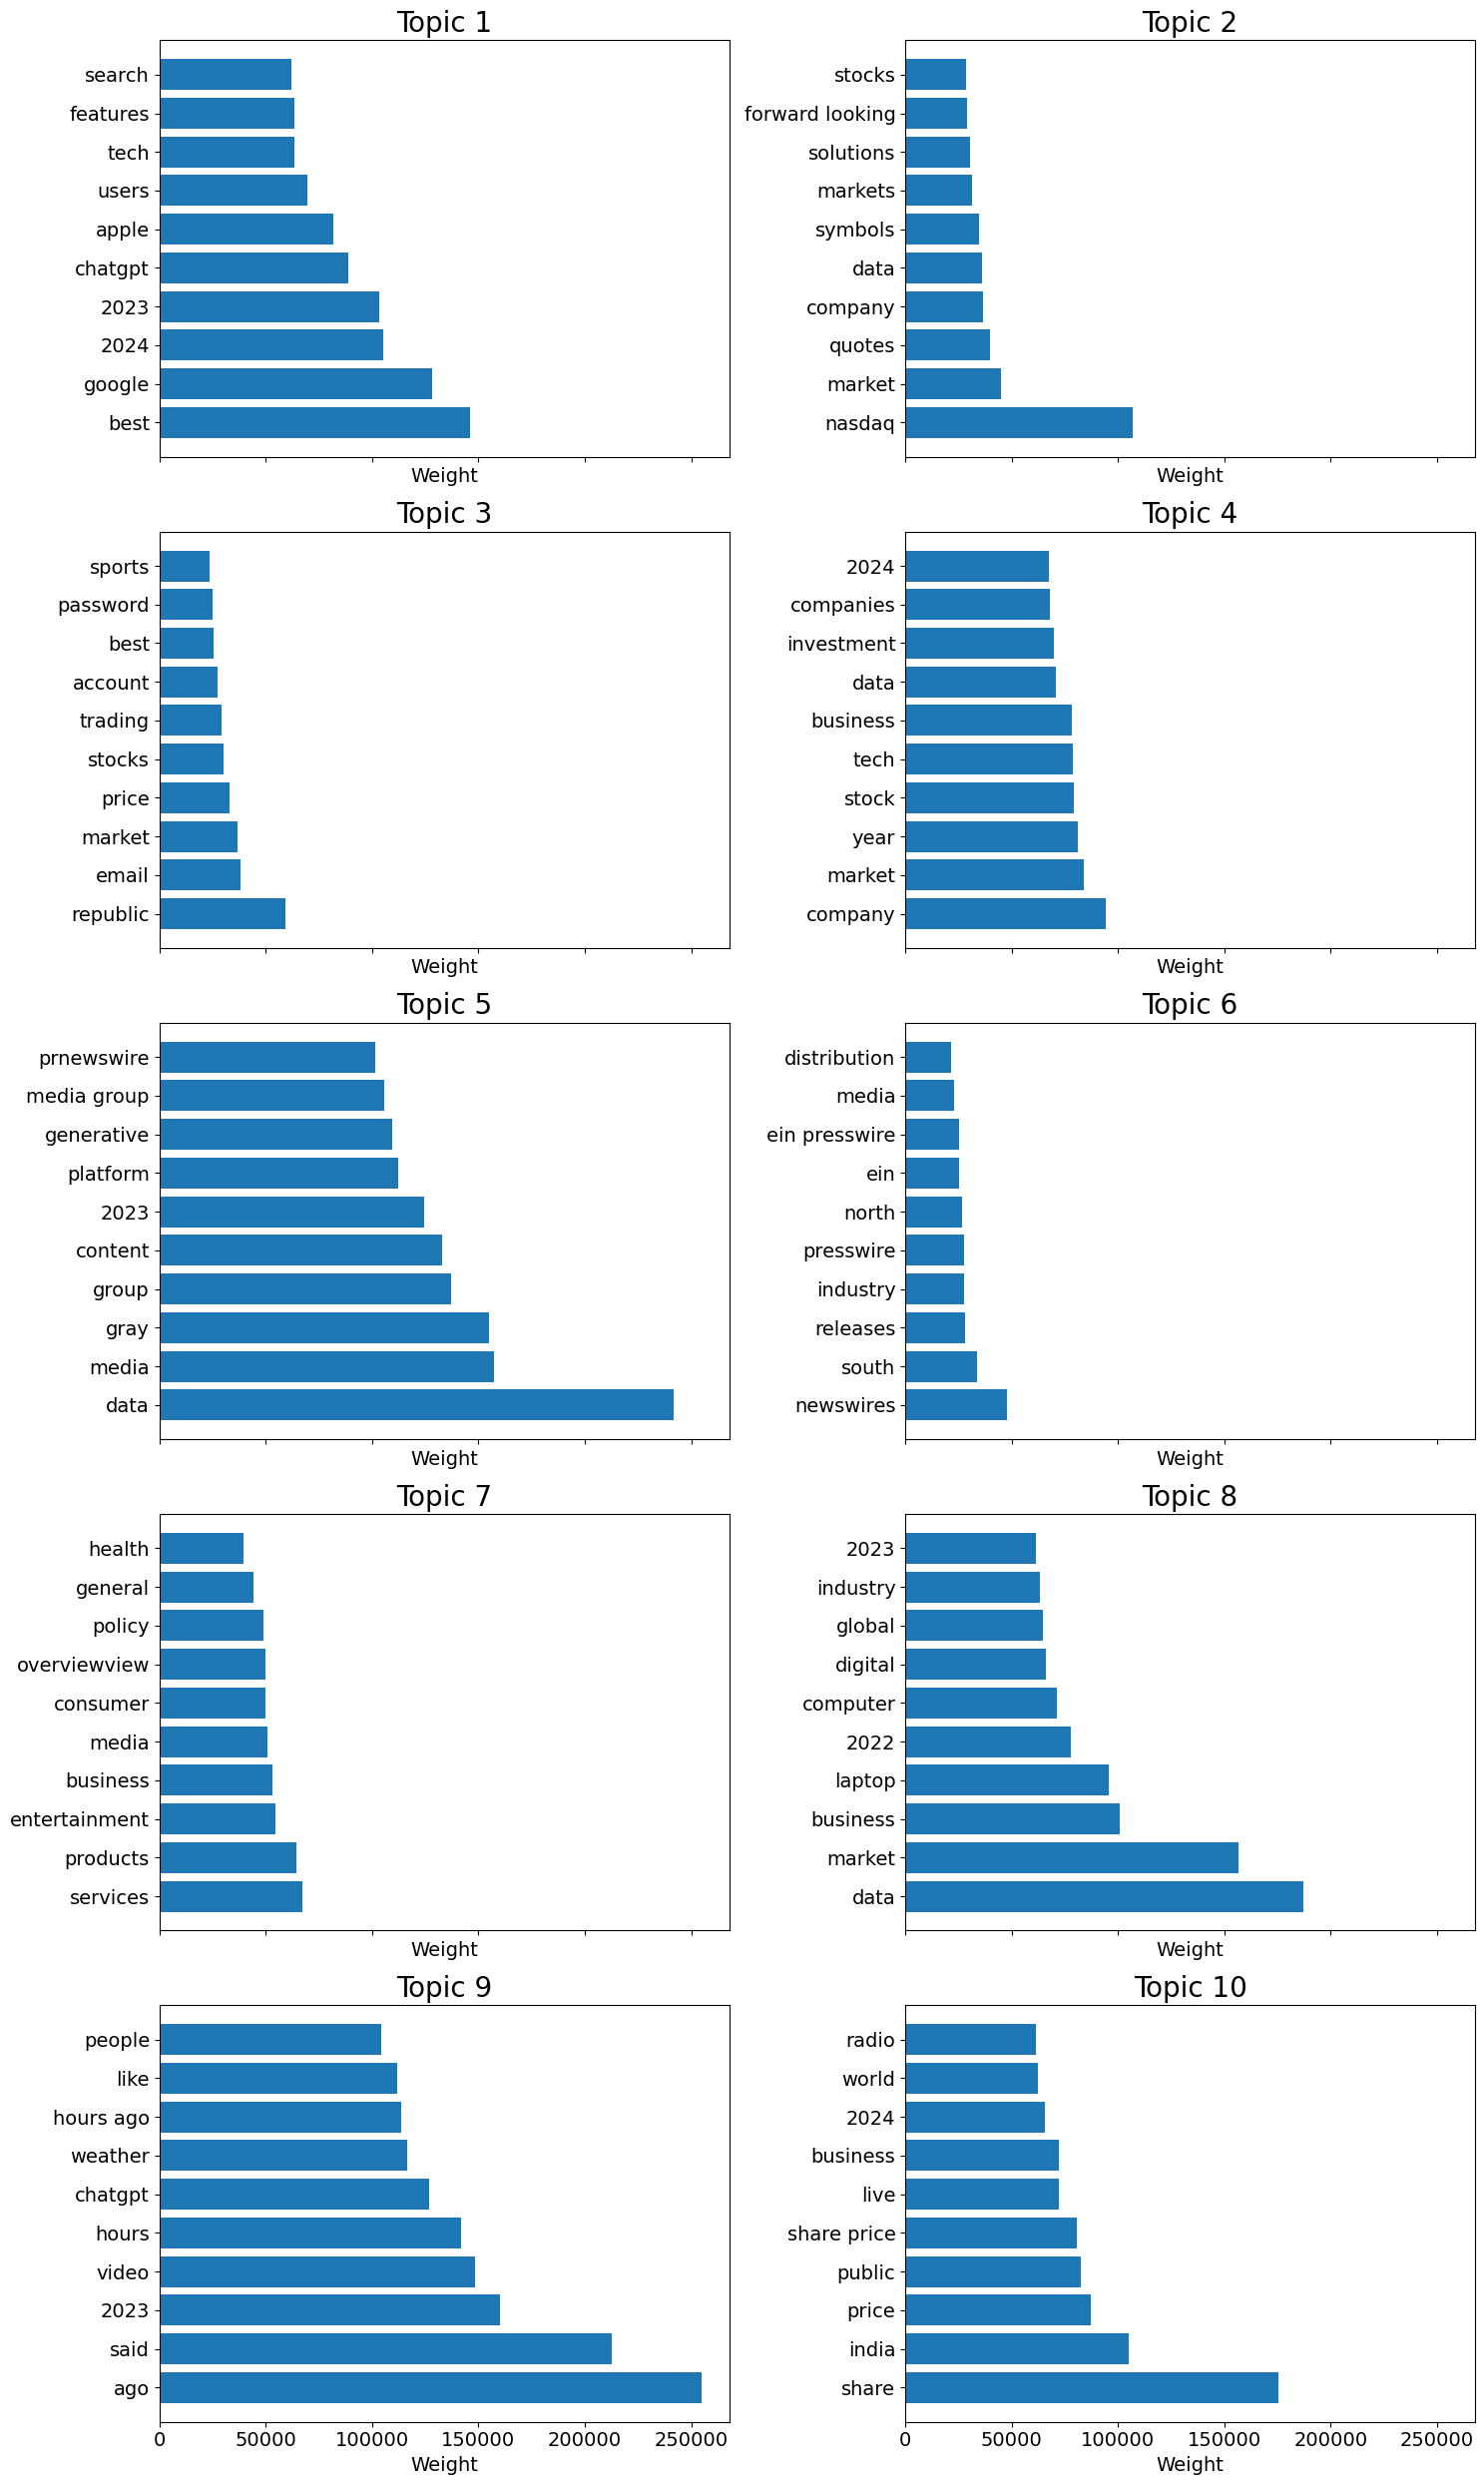

<Figure size 1200x600 with 0 Axes>

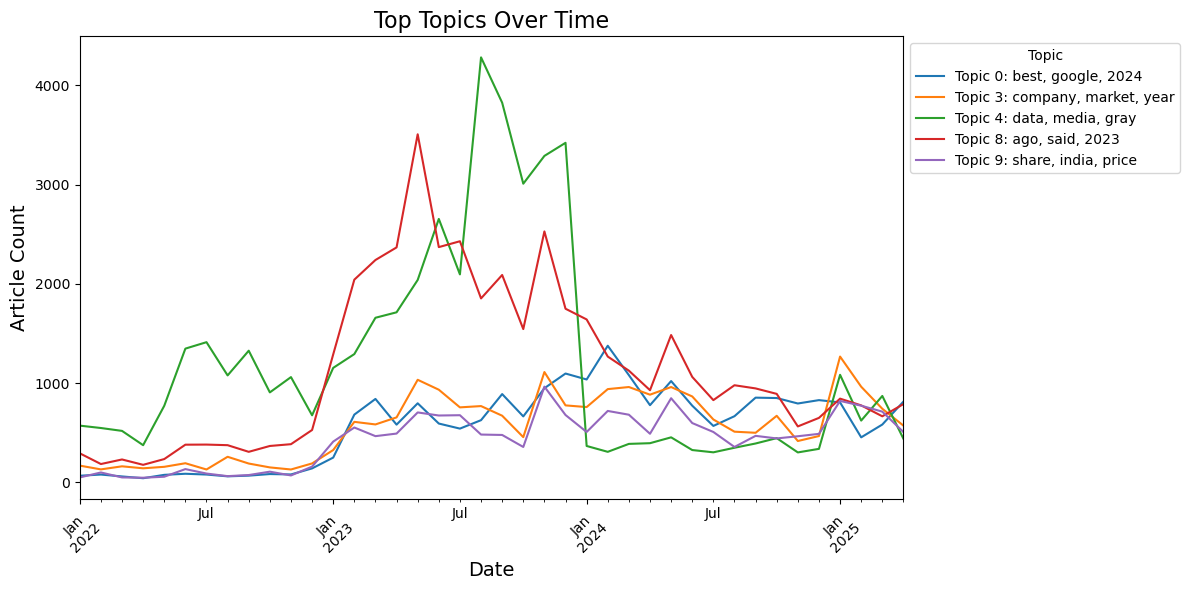

In [5]:
# Topic modeling run.
if df_clean is not None:
    print("Starting topic modeling.")
    lda, doc_topics, feature_names, topic_terms = run_topic_modeling(
        df_clean, 
        num_topics=10, 
        force_recompute=True
    )
    
    if lda is not None:
        # Added the topic to each document.
        df_clean['topic'] = doc_topics
        
        print("Topic visualizations.")
        
        # Top words for each topic plot.
        fig1 = plot_topics(lda, feature_names, n_top_words=10, save_path="topic_words.png")
        
        # Topics over time plot.
        fig2 = plot_topics_over_time(df_clean, doc_topics, topic_terms, top_n_topics=5, save_path="topics_over_time.png")
        
        # Saved DataFrame with the topics.
        save_to_cache(df_clean, "data_with_topics.pkl")
        
        print("Saved topic visualization to 'topic_words.png'")
        print("Saved topics over time to 'topics_over_time.png'")
        print("Saved enriched data to cache as 'data_with_topics.pkl'")
    else:
        print("Error: Topic modeling failed.")
else:
    print("Cannot run topic modeling because no valid data was loaded.")

In [6]:
# Summary of the topics with the top words.
def summarize_topics(lda, feature_names, n_top_words=10):
    topic_summaries = []
    for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topic_summaries.append(f"Topic {topic_idx + 1}: " + ", ".join(top_features))
    return topic_summaries
if lda is not None:
    topic_summaries = summarize_topics(lda, feature_names, n_top_words=10)
    for summary in topic_summaries:
        print(summary)

Topic 1: best, google, 2024, 2023, chatgpt, apple, users, tech, features, search
Topic 2: nasdaq, market, quotes, company, data, symbols, markets, solutions, forward looking, stocks
Topic 3: republic, email, market, price, stocks, trading, account, best, password, sports
Topic 4: company, market, year, stock, tech, business, data, investment, companies, 2024
Topic 5: data, media, gray, group, content, 2023, platform, generative, media group, prnewswire
Topic 6: newswires, south, releases, industry, presswire, north, ein, ein presswire, media, distribution
Topic 7: services, products, entertainment, business, media, consumer, overviewview, policy, general, health
Topic 8: data, market, business, laptop, 2022, computer, digital, global, industry, 2023
Topic 9: ago, said, 2023, video, hours, chatgpt, weather, hours ago, like, people
Topic 10: share, india, price, public, share price, live, business, 2024, world, radio


Word cloud for Topic 1 saved as 'wordcloud_topic_0.png'
Word cloud for Topic 2 saved as 'wordcloud_topic_1.png'
Word cloud for Topic 3 saved as 'wordcloud_topic_2.png'
Word cloud for Topic 4 saved as 'wordcloud_topic_3.png'
Word cloud for Topic 5 saved as 'wordcloud_topic_4.png'
Word cloud for Topic 6 saved as 'wordcloud_topic_5.png'
Word cloud for Topic 7 saved as 'wordcloud_topic_6.png'
Word cloud for Topic 8 saved as 'wordcloud_topic_7.png'
Word cloud for Topic 9 saved as 'wordcloud_topic_8.png'
Word cloud for Topic 10 saved as 'wordcloud_topic_9.png'


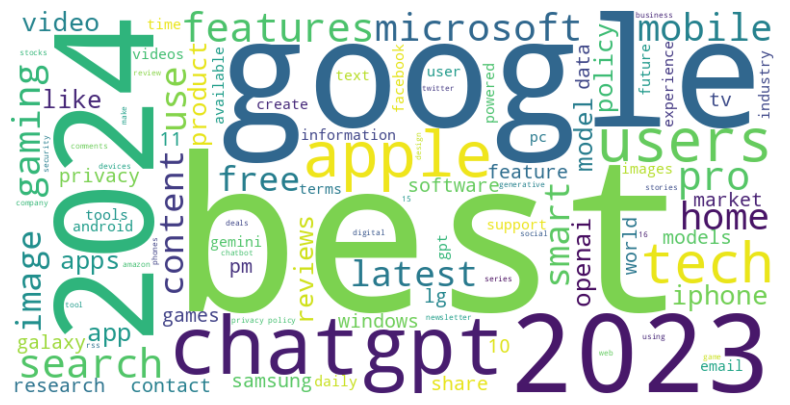

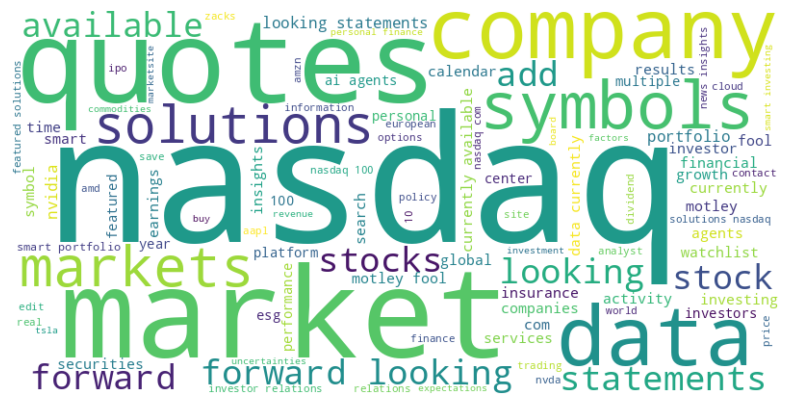

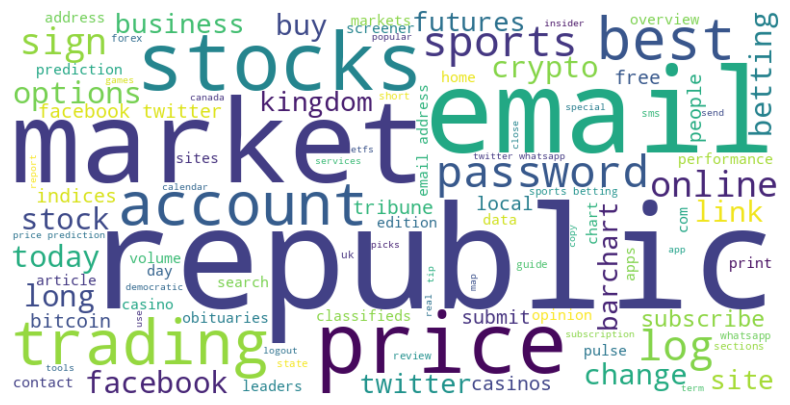

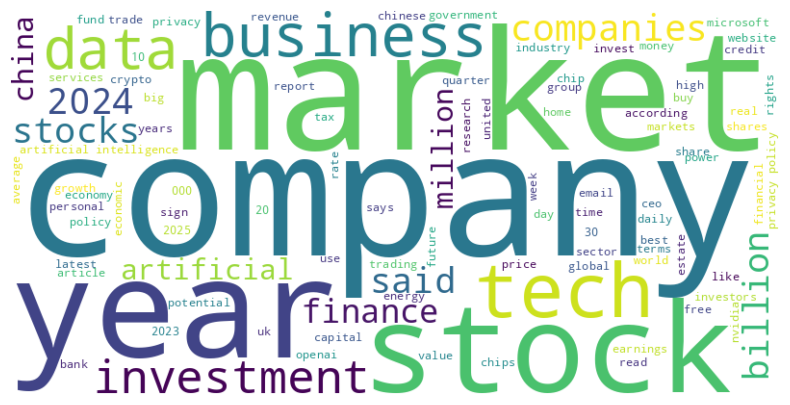

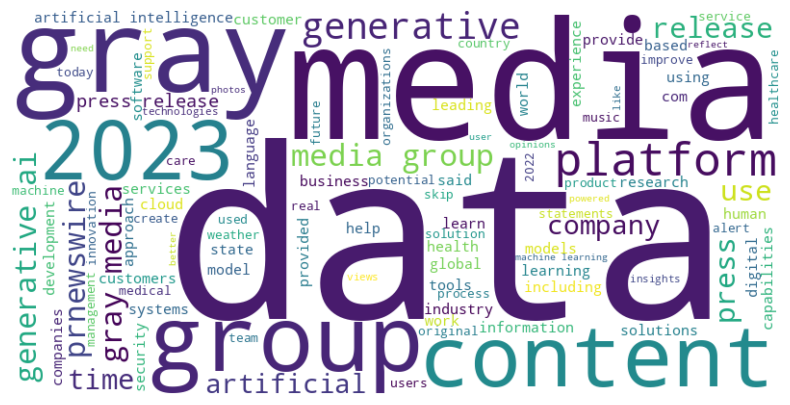

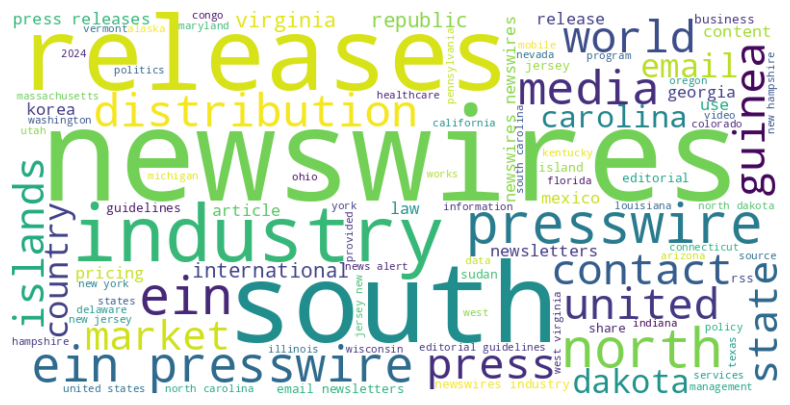

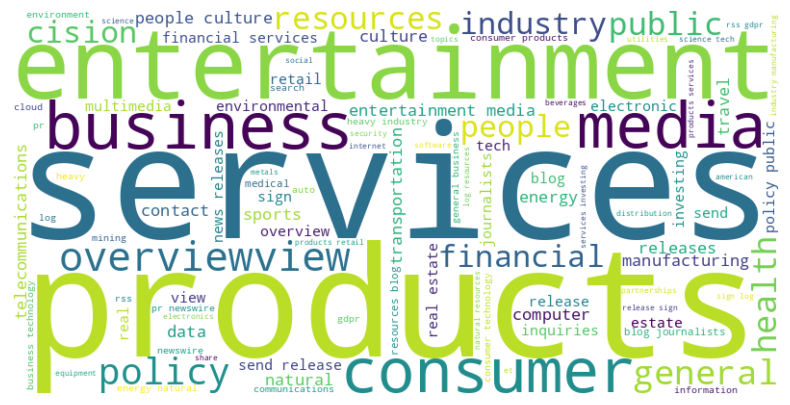

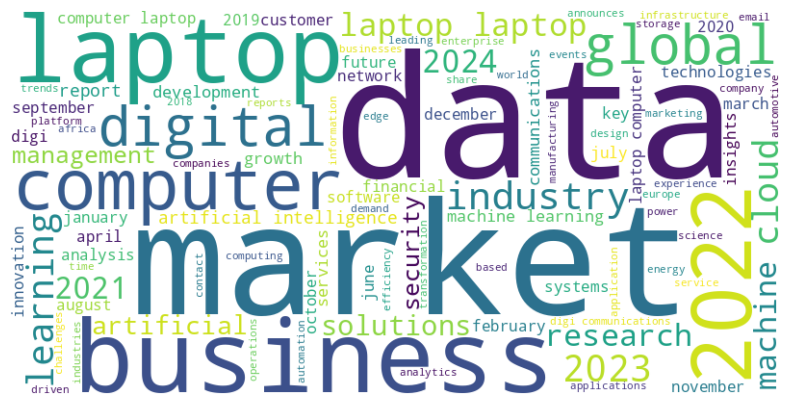

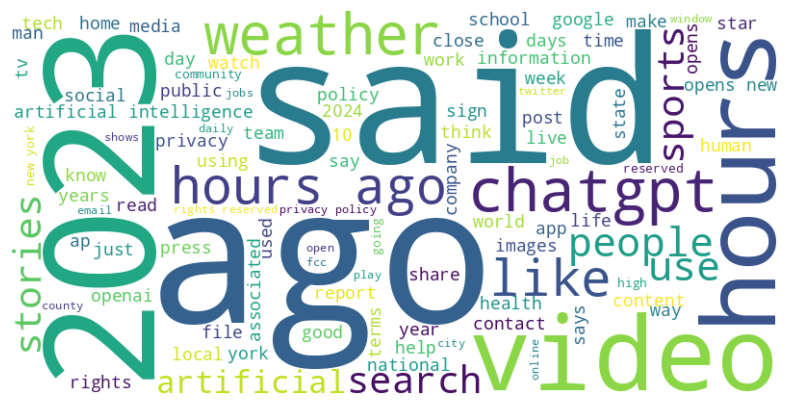

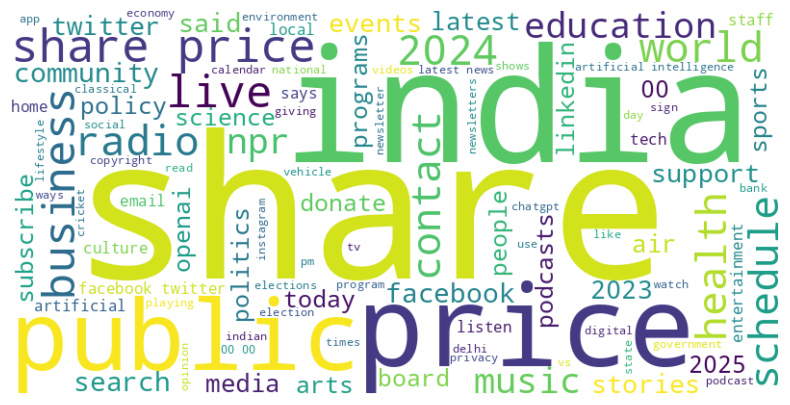

In [7]:
# Wordclouds.
from wordcloud import WordCloud

# Word cloud for each topic.
def plot_wordcloud(lda, feature_names, topic_idx, save_path=None):
    topic = lda.components_[topic_idx]
    top_features_ind = topic.argsort()[:-100 - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(top_features, weights)))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    return plt.gcf()
if lda is not None:
    for i in range(len(topic_terms)):
        plot_wordcloud(lda, feature_names, i, save_path=f"wordcloud_topic_{i}.png")
        print(f"Word cloud for Topic {i + 1} saved as 'wordcloud_topic_{i}.png'")

# Topic Summary

# LDA Topic to Industry Mapping

| **Topic** | **Top Words** | **Suggested Industry** | **Rationale** |
|-----------|----------------|-------------------------|----------------|
| **Topic 1** | best, google, 2024, chatgpt, apple, users, tech | **Consumer Tech & AI** | Highlights major tech brands and AI trends; relevant to consumer-facing innovation. |
| **Topic 2** | nasdaq, market, stocks, company, data, quotes | **Financial Markets & Investing** | Direct references to NASDAQ, market behavior, and financial instruments. |
| **Topic 3** | republic, email, trading, stocks, price, sports, password | **Online Services & Digital Trading** | Mix of account access, fintech, and online platform terms. |
| **Topic 4** | company, market, stock, investment, tech, year | **Corporate Finance & Tech Investing** | Business finance combined with tech investment context. |
| **Topic 5** | data, media, gray, content, generative, prnewswire | **Media & Generative AI Platforms** | PR and media firms, generative content, and AI usage in media. |
| **Topic 6** | newswires, south, releases, presswire, distribution | **Press Release & News Distribution** | Newswire services and regional content distribution platforms. |
| **Topic 7** | services, products, consumer, entertainment, media | **Consumer Services & Entertainment** | Consumer policy, entertainment media, and business services. |
| **Topic 8** | data, market, business, digital, global, laptop | **IT Hardware & Global Tech** | Focus on computing, hardware, and globalized digital business. |
| **Topic 9** | ago, said, video, chatgpt, weather, people | **Digital News & Social Trends** | Viral media, conversational content, and AI-related news. |
| **Topic 10** | share, india, price, business, radio, public | **International Business & Public Equity** | Shares, global financial coverage, and public market indicators. |